## Session 6


Convolutional Autoencoder

In [2]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from model import Encoder, Decoder
from evaluator import AutoEncoderEvaluator

## Use latent features to train and test a simple MLP

In [3]:
def load_model(model_name, key='state_dict_encoder'):
    model_dir = '../Session6/model/' + model_name
    checkpoint = torch.load(model_dir)
    checkpoint = checkpoint[key]
    return checkpoint

In [43]:
batch_size = 100
lr = 0.001
# Model
l2 = 0.0
optim = 'adam'
model_epoch = 19
use_gpu= True
cudnn.benchmark = True

model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [44]:
encoder.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05

In [45]:
decoder.eval()

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=

In [46]:
from matplotlib import pyplot as plt

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff4498b5a90>>
Traceback (most recent call last):
  File "/home/asif/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/asif/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/asif/anaconda3/lib/python3.6/multiprocessing/queues.py", line 345, in get
    return _ForkingPickler.loads(res)
  File "/home/asif/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/asif/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/asif/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_conne

Actual Input


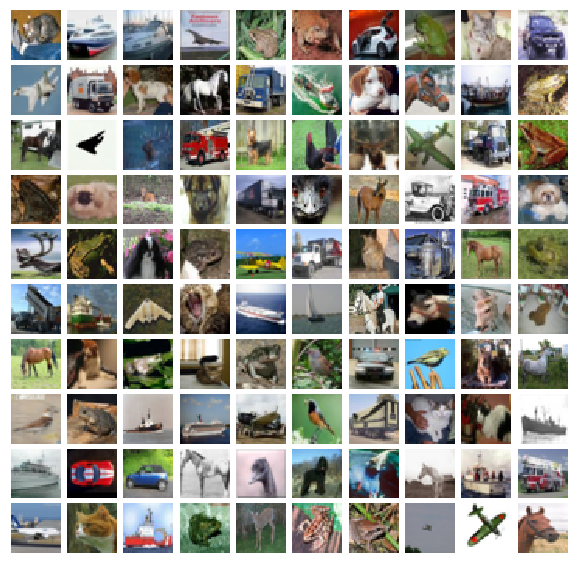

Reconstructed Output


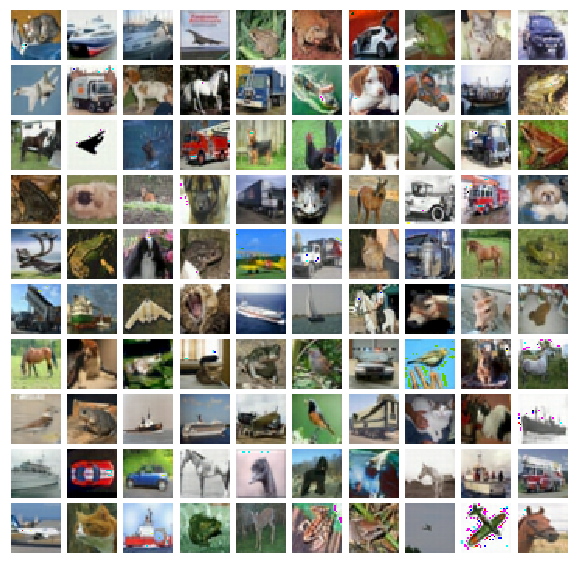

In [47]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

def plot_img(tensor, num_cols=10):
  num_imgs = tensor.shape[0]
  num_rows = 1+ num_imgs // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_imgs):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i].transpose((1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

for images, labels in testloader:
    output = encoder.forward(images)
    output = decoder.forward(output)
    break

print('Actual Input')
plot_img(images.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())   

In [48]:
import numpy as np
from tqdm import tqdm

In [ ]:
add_noise = False
n_in = 32768  # 512x8x8
train_features_ = np.zeros([len(trainloader), batch_size, n_in])
train_labels_ = np.zeros([len(trainloader),batch_size])
for b_idx, (train_data, train_labels) in tqdm(enumerate(trainloader)):
    
    latent_repr = encoder.forward(train_data)
    train_features_[b_idx,:,:] = latent_repr.detach().cpu().numpy()
    train_labels_[b_idx,:] = train_labels.detach().cpu().numpy()

147it [06:34,  2.68s/it]

In [ ]:
shape = train_features_.shape
train_features_ = train_features_.reshape(shape[0]*shape[1], shape[2])
train_labels_ = train_labels_.reshape(shape[0]*shape[1])

In [35]:
test_features_ = np.zeros([len(testloader), batch_size, n_in])
test_labels_ = np.zeros([len(testloader), batch_size])
for b_idx, (test_data, test_labels) in tqdm(enumerate(testloader)):
    latent_repr = encoder.forward(test_data)
    test_features_[b_idx,:,:] = latent_repr.detach().cpu().numpy()
    test_labels_[b_idx,:] = test_labels.detach().cpu().numpy()

100it [04:13,  2.54s/it]


In [41]:
shape = test_features_.shape
test_features_ = test_features_.reshape(shape[0]*shape[1], shape[2])
test_labels_.reshape(shape[0]*shape[1])

(100, 100)

In [23]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

predict_labels = OneVsRestClassifier(LinearSVC(random_state=0)).fit(train_features_, train_labels_).predict(test_features_)
print(classification_report(test_labels_, predict_labels))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      9824
        1.0       0.31      0.27      0.29        15
        2.0       0.13      0.21      0.16        14
        3.0       0.55      0.20      0.29        30
        4.0       0.25      0.17      0.20        24
        5.0       0.24      0.33      0.28        18
        6.0       0.24      0.33      0.28        15
        7.0       0.56      0.45      0.50        20
        8.0       0.48      0.50      0.49        26
        9.0       0.35      0.50      0.41        14

avg / total       0.99      0.99      0.99     10000



## Denoising AutoEncoder

Add noise to encoder

In [ ]:
# Set Hyperparameters
epochs = 10
batch_size = 50
lr = 0.001
l2 = 0.0
optim = 'adam'
model_epoch = 19
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [ ]:
encoder.eval()

In [ ]:
decoder.eval()

In [ ]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


for images, labels in testloader:
    output = encoder.forward(images)
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
    output = decoder.forward(image_n)
    break

print('Actual Images')
plot_img(images.detach().cpu().numpy())
print('Input Images')
plot_img(images_n.detach().cpu().numpy())

print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())   

In [ ]:
add_noise = True
train_features_ = np.zeros([len(trainloader), batch_size, n_in])
train_labels_ = np.zeros([len(trainloader), batch_size])
for b_idx, (train_data, train_labels) in enumerate(trainloader):
    train_data_n = torch.mul(train_data+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
    latent_repr = encoder.forward(train_data_n)
    train_features_dn[b_idx,:,:] = latent_repr.detach().cpu().numpy()
    train_labels_dn[b_idx,:] = train_labels.detach().cpu().numpy()

In [ ]:
shape = train_features_.shape
train_features_ = train_features_.reshape(shape[0]*shape[1], shape[2])
train_labels_ = train_labels_.reshape(shape[0]*shape[1])

In [ ]:
test_features_ = np.zeros([len(testloader), batch_size, n_in])
test_labels_ = np.zeros([len(testloader), batch_size])
for b_idx, (test_data, test_labels) in enumerate(testloader):
    latent_repr = encoder.forward(train_data)
    test_features_[b_idx,:,:] = latent_repr.detach().cpu().numpy()
    test_labels_[b_idx,:] = test_labels.detach().cpu().numpy()

In [ ]:
shape = test_features_.shape
test_features_ = test_features_.reshape(shape[0]*shape[1], shape[2])
test_labels_ = test_labels_.reshape(shape[0]*shape[1])

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

predict_labels = OneVsRestClassifier(LinearSVC(random_state=0)).fit(train_features_, train_labels_).predict(test_features_)
print(classification_report(test_labels_, predict_labels))

## Get latent features from Soccer Dataset and train a logistic regression classifier

In [ ]:
from test_soccer import get_features_soccer

In [ ]:
# Set Hyperparameters
epochs = 10
batch_size = 50
lr = 0.001
l2 = 0.0
optim = 'adam'
model_epoch = 10
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [ ]:
train_features_soc, train_labels_soc = get_soccer_latent(encoder)

model =  LinearSVC(random_state=0)
model = model.fit(train_features_soc, train_labels_soc)

predict_labels_soc = model.predict(test_features_soc)
print(classification_report(train_labels_soc, predict_labels_soc))

In [ ]:
def test_img(path, encoder, model):
    img = Image.open(path)
    plt.imshow(img)
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = transform(img)
    img = img.numpy()
    img = img[np.newaxis, ...]
    img = torch.Tensor(img)

    encoder.eval()

    with torch.no_grad():
        latent_repr = encoder.forward(img)
        latent_repr = latent_repr.detach().cpu().numpy()
        output = model.predict(latent_repr)
        print('prediction: {}'.format(['not soccer', 'soccer'][output])

## Test classifier on new images

In [ ]:
test_path = 'Session6/SoccerData/test'
img1_path = test_path + '/test1.jpg'
test_img(img1_path, encoder, model)